In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import sys
import cmocean

In [3]:
def approximate_z(ds, dim = "zl"):
    tmp = ds.thkcello.cumsum(dim = dim)
    #average between 0 and cell bottom
    tmp1 = tmp.isel({dim: 0}) / 2 
    #get top of cell
    tmp2 = tmp.isel({dim : slice(0, -1)}) 
    #get bottom of cell
    tmp3 = tmp.isel({dim : slice(1, None)}) 
    #make sure cell interfaces are on same coordinate
    tmp2.coords[dim] = tmp3.coords[dim]
    #take average
    tmp4 = (tmp2 + tmp3) / 2

    ds["z"] = xr.concat([1. * tmp1, 1. * tmp4], dim = dim)    
    ds["z_bottom"] = 1. * tmp

    return ds
    

In [4]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.2.1 
xwmb version 0.2.1


### Request HPC Resources

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='25GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0', 
log_directory ="/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/slurmscratch")
print(cluster.job_script())
cluster.scale(jobs=2)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/slurmscratch/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/slurmscratch/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=24G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.91:34290 --name dummy-name --nthreads 36 --memory-limit 23.28GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.91:34290,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Task exception was never retrieved
future: <Task finished name='Task-59' coro=<Client._gather.<locals>.wait() done, defined at /vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/distributed/client.py:2391> exception=AllExit()>
Traceback (most recent call last):
  File "/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/distributed/client.py", line 2400, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-58' coro=<Client._gather.<locals>.wait() done, defined at /vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/distributed/client.py:2391> exception=AllExit()>
Traceback (most recent call last):
  File "/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/distributed/client.py", line 2400, in wait
    raise AllExit()
distributed.client.AllExit


### Load in data

In [5]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmol kg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

fname = "../../../data/model/budgets_sigma2/CM4Xp25_budgets_sigma2_1975-1979.zarr"
# fname = "../../../data/model/CM4Xp25_ssp585_tracers_sigma2_2020-2024.zarr"

ds = xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")

ds = ds.fillna(0.) #remove all NaNs
ds['mask'] = (
    (ds['geolat'] <= -40)
)

grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")
grid._ds = grid._ds.assign_coords({
    "sigma2_l_target": grid._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
    "sigma2_i_target": grid._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
})
grid = xwmt.add_gridcoords(
    grid,
    {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
    {"Z_target": "extend"}
)


In [44]:
ds[

<xarray.Dataset> Size: 12GB
Dimensions:                         (exp: 2, time: 60, yh: 90, xh: 120,
                                     sigma2_l: 74, time_bounds: 61, xq: 121,
                                     yq: 91, sigma2_i: 75)
Coordinates: (12/30)
    areacello                       (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    deptho                          (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    dxCv                            (yq, xh) float64 87kB dask.array<chunksize=(91, 120), meta=np.ndarray>
    dyCu                            (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
  * exp                             (exp) object 16B 'forced' 'control'
    geolat                          (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    ...                              ...
    wet_u                           (yh, xq) float32 44kB dask.array<chunksize=(90, 121), meta=np.ndarray>
    wet_v                           (yq, xh) float32 44kB dask.array<chunksize=(91, 120), meta=np.ndarray>
  * xh                              (xh) int64 960B 0 1 2 3 ... 116 117 118 119
  * xq                              (xq) int64 968B 0 1 2 3 ... 117 118 119 120
  * yh                              (yh) int64 720B 0 1 2 3 4 ... 85 86 87 88 89
  * yq                              (yq) int64 728B 0 1 2 3 4 ... 86 87 88 89 90
Data variables: (12/39)
    EVAP                            (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    LSNK                            (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    LSRC                            (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    RAIN                            (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    SNOWFL                          (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    S_advection_xy                  (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    ...                              ...
    tos                             (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    umo                             (exp, time, sigma2_l, yh, xq) float64 774MB dask.array<chunksize=(2, 60, 74, 90, 121), meta=np.ndarray>
    vert_remap_h_tendency           (exp, time, sigma2_l, yh, xh) float32 384MB dask.array<chunksize=(2, 60, 74, 90, 120), meta=np.ndarray>
    vmo                             (exp, time, sigma2_l, yq, xh) float64 776MB dask.array<chunksize=(2, 60, 74, 91, 120), meta=np.ndarray>
    wfo                             (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    mask                            (yh, xh) bool 11kB dask.array<chunksize=(90, 120), meta=np.ndarray>
Attributes:
    associated_files:    areacello: 19750101.ocean_static.nc
    description:         The CM4Xp25 experimental design following Griffies e...
    external_variables:  volcello areacello
    filename:            ocean_monthly_z.197501-197912.S_advection_xy.nc
    grid_tile:           N/A
    grid_type:           regular
    model:               CM4Xp25
    provenance:          Diagnostics have been conservatively remapped into m...
    title:               CM4_historical_c192_OM4p25
    version:             v0.1.0

In [43]:
ds["boundary_forcing_heat_tendency"]

<xarray.DataArray 'boundary_forcing_heat_tendency' (exp: 2, time: 60,
                                                    sigma2_l: 74, yh: 90,
                                                    xh: 120)> Size: 384MB
dask.array<where, shape=(2, 60, 74, 90, 120), dtype=float32, chunksize=(2, 60, 74, 90, 120), chunktype=numpy.ndarray>
Coordinates: (12/14)
    areacello        (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    deptho           (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
  * exp              (exp) object 16B 'forced' 'control'
    geolat           (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    geolon           (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    lat              (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    ...               ...
  * sigma2_l         (sigma2_l) float64 592B 4.246 13.57 17.71 ... 37.9 38.49
  * time             (time) object 480B 1975-01-16 12:00:00 ... 1979-12-16 12...
    time_since_init  (time) object 480B dask.array<chunksize=(60,), meta=np.ndarray>
    wet              (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
  * xh               (xh) int64 960B 0 1 2 3 4 5 6 ... 114 115 116 117 118 119
  * yh               (yh) int64 720B 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean sigma2_l:sum yh:mean xh:mean time:mean
    long_name:      Boundary forcing heat tendency
    time_avg_info:  average_T1,average_T2,average_DT
    units:          W m-2

Text(0.5, 1.0, 'Southern Ocean mask')

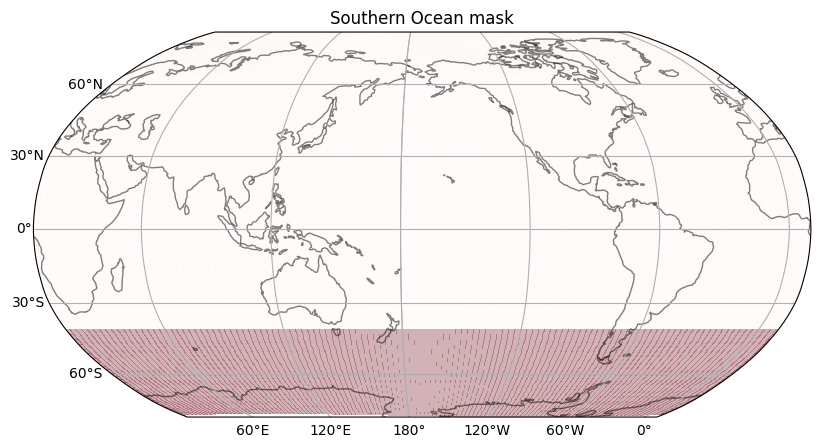

In [6]:
fig, ax = plt.subplots(figsize=[20,5], subplot_kw={'projection':ccrs.Robinson(190)})
ax.pcolormesh(ds['geolon'], ds['geolat'] , ds['mask'], 
              transform = ccrs.PlateCarree(), cmap = "Reds", alpha = 0.3)
ax.coastlines(alpha = 0.5)
gl = ax.gridlines(draw_labels = True)
gl.top_labels = False
gl.right_labels = False
ax.set_title("Southern Ocean mask")

In [7]:
regions = MaskRegions(ds.mask, grid).region_dict
antarctic = regions[0] #there are more in this list if there are multiple contours 
region = GriddedRegion("antarctic", antarctic.lons, antarctic.lats, grid, ij=(antarctic.i, antarctic.j))

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
    xbudget.collect_budgets(grid, budgets_dict)
    
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict, 
    ) #if region not passed, the whole globe is taken
    wmb.mass_budget("sigma2", greater_than=True, default_bins=False, 
                    integrate=True, along_section=False)
wmb.wmt
    #wmb.grid._ds["z"] this is where the z's are 

<xarray.Dataset> Size: 3MB
Dimensions:                                         (exp: 2, time: 60,
                                                     sigma2_l_target: 74,
                                                     sigma2_i_target: 75,
                                                     time_bounds: 61, yh: 90,
                                                     xh: 120)
Coordinates: (12/17)
  * exp                                             (exp) object 16B 'forced'...
  * time                                            (time) object 480B 1975-0...
    time_since_init                                 (time) object 480B dask.array<chunksize=(60,), meta=np.ndarray>
    rho2_l                                          (sigma2_l_target) float64 592B dask.array<chunksize=(74,), meta=np.ndarray>
  * sigma2_l_target                                 (sigma2_l_target) float64 592B ...
    rho2_i                                          (sigma2_i_target) float64 600B dask.array<chunksize=(75,), meta=np.ndarray>
    ...                                              ...
    geolon                                          (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    lat                                             (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    lon                                             (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    wet                                             (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
  * xh                                              (xh) int64 960B 0 1 ... 119
  * yh                                              (yh) int64 720B 0 1 ... 89
Data variables: (12/39)
    Eulerian_tendency_heat                          (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    Eulerian_tendency_salt                          (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    surface_ocean_flux_advective_negative_lhs_heat  (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    surface_ocean_flux_advective_negative_lhs_salt  (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    advection_heat                                  (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    advection_salt                                  (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    ...                                              ...
    mass_tendency                                   (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    dt                                              (time) float64 480B 2.678...
    realized_transformation                         (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    spurious_numerical_mixing                       (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    advection_plus_BC                               (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    diabatic_advection                              (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
    xbudget.collect_budgets(grid, budgets_dict)
    
    wmb2 = xwmb.WaterMassBudget(
        grid,
        budgets_dict, 
        decompose = ["surface_exchange_flux"]
    ) #if region not passed, the whole globe is taken
    wmb2.mass_budget("sigma2", greater_than=True, default_bins=False, 
                    integrate=True, along_section=False)
wmb2.wmt
    #wmb.grid._ds["z"] this is where the z's are 

<xarray.Dataset> Size: 4MB
Dimensions:                                                                   (
                                                                               exp: 2,
                                                                               time: 60,
                                                                               sigma2_l_target: 74,
                                                                               sigma2_i_target: 75,
                                                                               time_bounds: 61,
                                                                               yh: 90,
                                                                               xh: 120)
Coordinates: (12/17)
  * exp                                                                       (exp) object 16B ...
  * time                                                                      (time) object 480B ...
    time_since_init                                                           (time) object 480B dask.array<chunksize=(60,), meta=np.ndarray>
    rho2_l                                                                    (sigma2_l_target) float64 592B dask.array<chunksize=(74,), meta=np.ndarray>
  * sigma2_l_target                                                           (sigma2_l_target) float64 592B ...
    rho2_i                                                                    (sigma2_i_target) float64 600B dask.array<chunksize=(75,), meta=np.ndarray>
    ...                                                                        ...
    geolon                                                                    (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    lat                                                                       (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    lon                                                                       (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    wet                                                                       (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
  * xh                                                                        (xh) int64 960B ...
  * yh                                                                        (yh) int64 720B ...
Data variables: (12/48)
    Eulerian_tendency_heat                                                    (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    Eulerian_tendency_salt                                                    (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    surface_ocean_flux_advective_negative_lhs_heat                            (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    surface_ocean_flux_advective_negative_lhs_salt                            (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    surface_exchange_flux_var_heat                                            (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    surface_exchange_flux_var_salt                                            (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    ...                                                                        ...
    mass_tendency                                                             (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    dt                                                                        (time) float64 480B ...
    realized_transformation                                                   (exp, time, sigma2_l_target) float64 71kB dask.array<chunksize=(2, 60, 74), meta=np.ndarray>
    spurio

#### Decomposing tendencies
Density tendencies in `wmb.wmt` can be decomposed into their heat and salt components using ``wmb.rho_tend``. This is done by a linearization of the equation of state (i think) so that a tendency $Q$ can be written as the sum of temperature and salintity terms $Q_\theta$ and $Q_S$: 
$$ Q = \frac{-\alpha Q_\theta + \beta Q_S}{c_p}$$
where $\alpha$ and $\beta$ are expansion coefficients and $c_p$ represents the specific heat of water



#### Surface exchange fluxes 
Let's consider "surface_exchange_flux", the variable that represents density fluxes due to heat and salt fluxes at the surface. Using the above relation, 
$$ Q^{SFC} = \frac{-\alpha Q^{SFC}_\theta + \beta Q^{SFC}_S}{c_p}$$
But, what is $Q^{SFC}_\theta$ for example? We can do this using XWMB and querying how the 'surface_exchange_flux' is calculated in temperature coordinates

In [16]:
import json
print(json.dumps(budgets_dict['heat']["rhs"]["sum"]["surface_exchange_flux"], sort_keys=True, indent=4))

{
    "product": {
        "area": "areacello",
        "tracer_content_tendency_per_unit_area": "boundary_forcing_heat_tendency",
        "var": "heat_rhs_sum_surface_exchange_flux_product"
    },
    "var": "heat_rhs_sum_surface_exchange_flux"
}


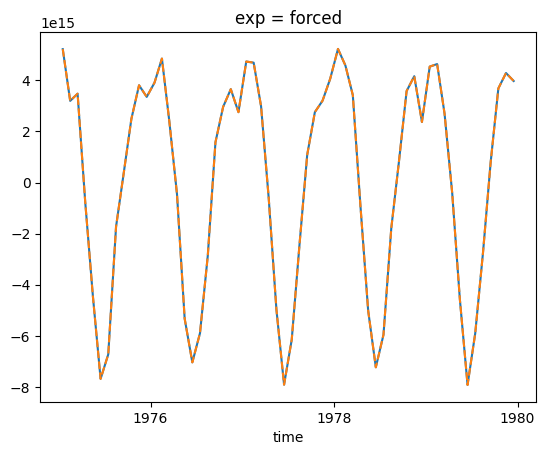

In [11]:
Qlhs = wmb.grid._ds["heat_rhs_sum_surface_exchange_flux_product"]
Qlhs = Qlhs.isel(exp = 0).sum(["sigma2_l", "xh", "yh"]).compute()
Qrhs = wmb.grid._ds["boundary_forcing_heat_tendency"]  * wmb.grid._ds.areacello
Qrhs =Qrhs.isel(exp = 0).sum(["sigma2_l", "xh", "yh"]).compute()

Qlhs.plot()
Qrhs.plot(linestyle = "--")

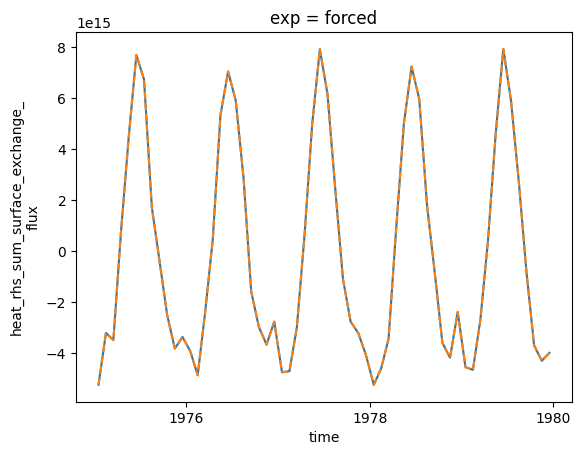

In [17]:
Qlhs = wmb.grid._ds["heat_rhs_sum_surface_exchange_flux_product"]
Qlhs = Qlhs.isel(exp = 0).sum(["sigma2_l", "xh", "yh"]).compute()

Qrhs = wmb.grid._ds["heat_rhs_sum_surface_exchange_flux"]
Qrhs = Qrhs.isel(exp = 0).sum(["sigma2_l", "xh", "yh"]).compute()

(-Qlhs).plot()
(-Qrhs).plot(linestyle = "--")

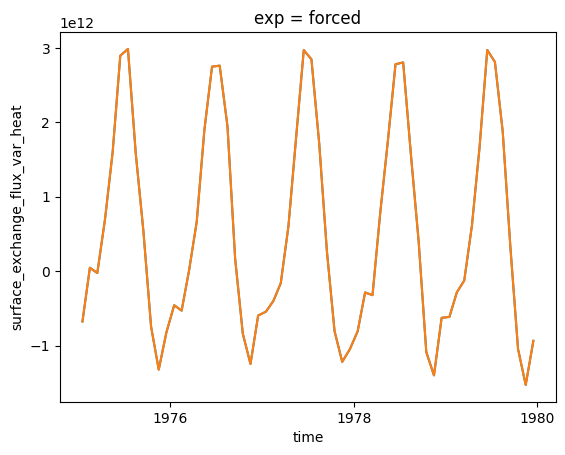

In [13]:
wmb.wmt["surface_exchange_flux_heat"].isel(exp = 0).sum("sigma2_l_target").plot()
wmb2.wmt["surface_exchange_flux_var_heat"].isel(exp = 0).sum("sigma2_l_target").plot()

In [26]:
Qlhs = wmb.grid._ds["heat_rhs_sum_surface_exchange_flux"]

In [41]:
wmb.grid._ds

<xarray.Dataset> Size: 74GB
Dimensions:                                                                                                 (
                                                                                                             exp: 2,
                                                                                                             time: 60,
                                                                                                             yh: 90,
                                                                                                             xh: 120,
                                                                                                             sigma2_l: 74,
                                                                                                             time_bounds: 61,
                                                                                                             xq: 121,
                                                                                                             yq: 91,
                                                                                                             sigma2_i_target: 75,
                                                                                                             sigma2_l_target: 74,
                                                                                                             sigma2_i: 75)
Coordinates: (12/32)
    areacello                                                                                               (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    deptho                                                                                                  (yh, xh) float32 43kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    dxCv                                                                                                    (yq, xh) float64 87kB dask.array<chunksize=(91, 120), meta=np.ndarray>
    dyCu                                                                                                    (yh, xq) float64 87kB dask.array<chunksize=(90, 121), meta=np.ndarray>
  * exp                                                                                                     (exp) object 16B ...
    geolat                                                                                                  (yh, xh) float64 86kB dask.array<chunksize=(90, 120), meta=np.ndarray>
    ...                                                                                                      ...
  * xh                                                                                                      (xh) int64 960B ...
  * xq                                                                                                      (xq) int64 968B ...
  * yh                                                                                                      (yh) int64 720B ...
  * yq                                                                                                      (yq) int64 728B ...
  * sigma2_l_target                                                                                         (sigma2_l_target) float64 592B ...
  * sigma2_i_target                                                                                         (sigma2_i_target) float64 600B ...
Data variables: (12/126)
    EVAP                                                                                                    (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    LSNK                                                                                                    (exp, time, yh, xh) float32 5MB dask.array<chunksize=(2, 60, 90, 120), meta=np.ndarray>
    LSRC                                                                                                    (exp, time, yh, xh) float32 5MB dask.array<

In [39]:
Qlhs = wmb.grid._ds["heat_rhs_sum_surface_exchange_flux"]
Qlhs = -Qlhs *  wmb.grid._ds.alpha  / wmb.cp 
Qlhs = Qlhs * wmb.rho_ref
Qlhs = Qlhs * wmb.grid._ds.thkcello
Qlhs = Qlhs.isel(exp = 0)
Qlhs = Qlhs.sum(["xh", "yh"]) 


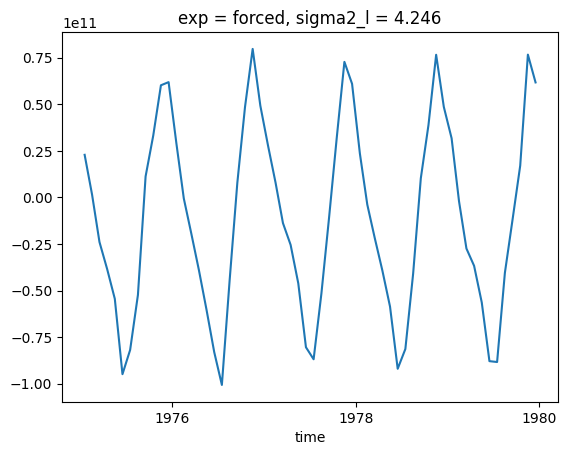

In [40]:
Qlhs.isel(sigma2_l = 0).compute().plot()


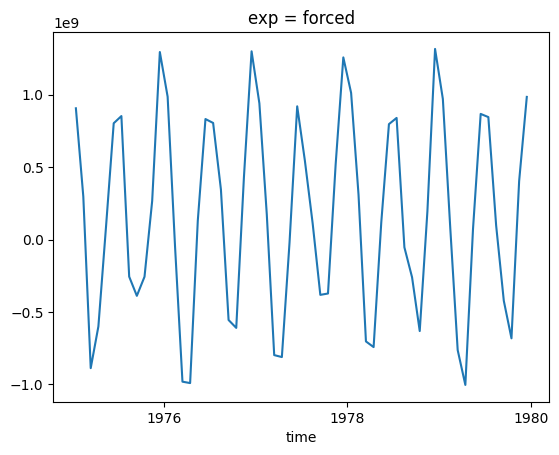

In [37]:
Qlhs.sum("sigma2_l").compute().plot()


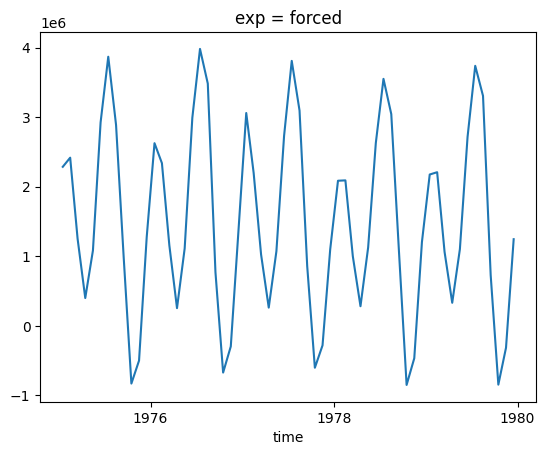

In [38]:
Qlhs = wmb.grid._ds["heat_rhs_sum_surface_exchange_flux"]
Qlhs = -Qlhs *  wmb.grid._ds.alpha  / wmb.cp 
Qlhs = Qlhs * wmb.rho_ref
Qlhs = Qlhs * wmb.grid._ds.thkcello
Qlhs = Qlhs.isel(exp = 0)
Qlhs = Qlhs.sum(["sigma2_l", "xh", "yh"]) /  wmb.grid._ds.thkcello.isel(exp = 0).sum(["sigma2_l", "xh", "yh"])
Qlhs.compute().plot()


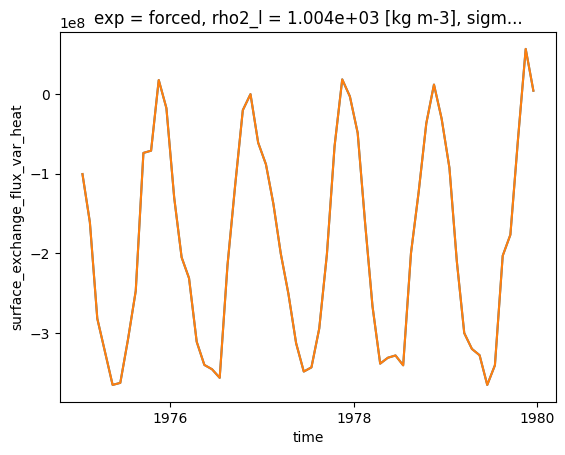

In [175]:
wmb.wmt["surface_exchange_flux_heat"].isel(exp = 0).isel(sigma2_l_target = 0 ).plot()
wmb2.wmt["surface_exchange_flux_var_heat"].isel(exp = 0).isel(sigma2_l_target = 0 ).plot()